# Evaluate Model
Notebook used for evaluating NNs matching parton jets to gen jets

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import sys

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(os.environ['CUDA_VISIBLE_DEVICES'])

0


In [3]:
sys.path.append('../src/')
import model

In [4]:
save_dir = '../models/Run_11_2020-09-25/'
assert(os.path.isdir(save_dir))

In [41]:
losses = np.loadtxt(save_dir + 'losses.csv', delimiter=',', skiprows=1)

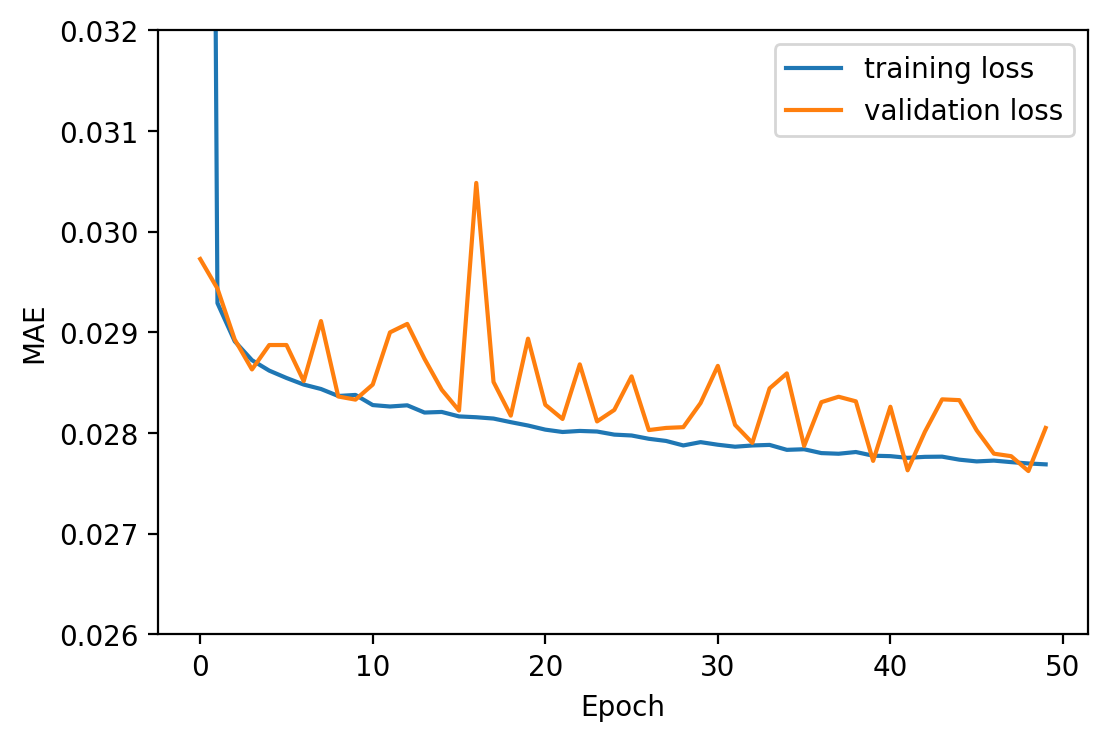

In [54]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(losses[:, 1], label='training loss')
ax.plot(losses[:, 2], label='validation loss')
ax.set_ylim(0.026, 0.032)
ax.set_ylabel("MAE")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [5]:
data = np.loadtxt("../data/txt/matchData.txt", skiprows=2)
partonMean = np.mean(data[:, :3], axis=0)
partonStd = np.std(data[:, :3], axis=0)
partonEMax = np.max(data[:, 3], axis=0)
partonEMin = np.min(data[:, 3], axis=0)
genMean = np.mean(data[:, 4:7], axis=0)
genStd = np.std(data[:, 4:7], axis=0)
genEMax = np.max(data[:, 7], axis=0)
genEMin = np.min(data[:, 7], axis=0)

data[:, :3] = (data[:, :3] - partonMean)/partonStd
data[:, 3] = (data[:, 3] - partonEMin)/partonEMax
data[:, 4:7] = (data[:, 4:7] - genMean)/genStd
data[:, 7] = (data[:, 7] - genEMin)/genEMax

In [6]:
index = int(0.8*len(data))
validate = data[index:, :]
validateParton = validate[:, :4]
validateGen = validate[:, 4:]
mse = keras.losses.MeanSquaredError()
naiveErr = mse(validateParton, validateGen).numpy()
print(naiveErr)

0.012868639081716537


In [7]:
checkpoint_path = save_dir + 'training/cp.cpkt'
net = model.make_model()
net.summary()
mse = keras.losses.MeanSquaredError()
net.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
           loss=mse,
           metrics=[keras.metrics.MeanAbsoluteError()])
net.load_weights(checkpoint_path)
prediction = net.predict(validateParton)
net.evaluate(validateParton, validateGen, batch_size=128)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 17,220
Trainable params: 17,220
Non-trainable params: 0
____________________________________________________

[0.012936819344758987, 0.027622997760772705]

In [8]:
mae = keras.losses.MeanAbsoluteError()

validate[:, :3] = (validate[:, :3])*partonStd + partonMean
validate[:, 3] = (validate[:, 3])*partonEMax + partonEMin
validate[:, 4:7] = (validate[:, 4:7])*genStd + genMean
validate[:, 7] = (validate[:, 7])*genEMax + genEMin
inputs = validate[:, :4]
prediction[:, :3] = prediction[:, :3]*genStd + genMean
prediction[:, 3] = (prediction[:, 3])*genEMax + genEMin
true = validate[:, 4:]

In [9]:
#calculate MAEs between components of parton and gen jets
naivePxErr = mae(inputs[:, 0], true[:, 0]).numpy()
print(naivePxErr)
naivePyErr = mae(inputs[:, 1], true[:, 1]).numpy()
print(naivePyErr)
naivePzErr = mae(inputs[:, 2], true[:, 2]).numpy()
print(naivePzErr)
naiveEErr = mae(inputs[:, 3], true[:, 3]).numpy()
print(naiveEErr)
naivePtErr = mae(np.sqrt((inputs[:, 0])**2 + (inputs[:, 1]**2)), np.sqrt((true[:, 0])**2 + (true[:, 1]**2))).numpy()
print(naivePtErr)

7.996945858001709
7.850292205810547
26.145828247070312
31.661231994628906
12.182266235351562


In [10]:
#calculate MAEs between components of predicted and gen jets
predPxErr = mae(prediction[:, 0], true[:, 0]).numpy()
print(predPxErr)
predPyErr = mae(prediction[:, 1], true[:, 1]).numpy()
print(predPyErr)
predPzErr = mae(prediction[:, 2], true[:, 2]).numpy()
print(predPzErr)
predEErr = mae(prediction[:, 3], true[:, 3]).numpy()
print(predEErr)
predPtErr = mae(np.sqrt((prediction[:, 0])**2 + (prediction[:, 1]**2)), np.sqrt((true[:, 0])**2 + (true[:, 1]**2))).numpy()
print(predPtErr)

7.899170398712158
7.771342754364014
24.54005241394043
30.860031127929688
11.834842681884766


## Histograms of Px

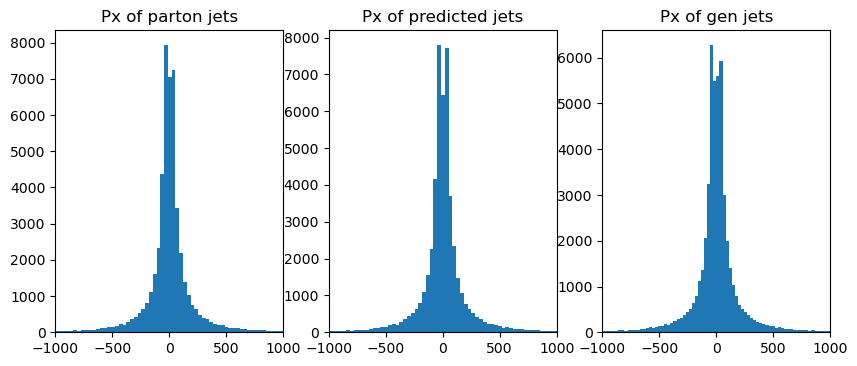

In [11]:
fig = plt.figure(figsize=(10,4), dpi=100)
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 0], bins=200)
ax1.set_title("Px of parton jets")
ax1.set_xlim(-1000, 1000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 0], bins=200)
ax2.set_title("Px of predicted jets")
ax2.set_xlim(-1000, 1000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 0], bins=200)
ax3.set_title("Px of gen jets")
ax3.set_xlim(-1000, 1000)
#plt.yscale('log')
plt.show()

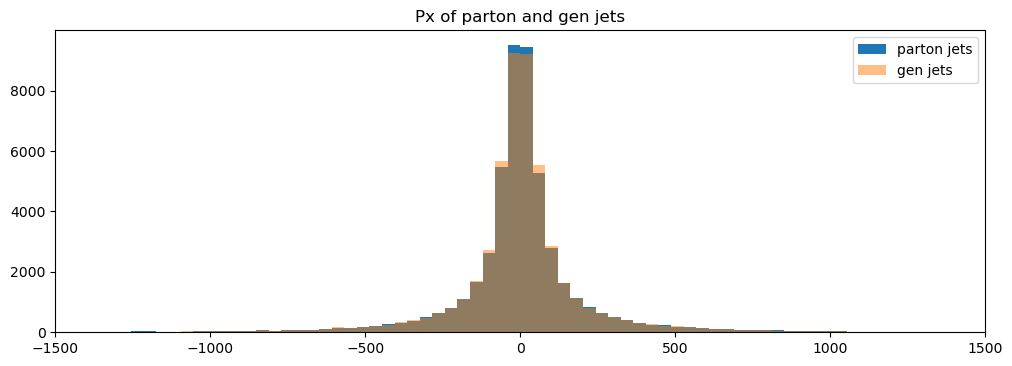

In [29]:
bins = np.linspace(-1500, 1500, 75)
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 0], bins=bins, label='parton jets')
ax1.hist(true[:, 0], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Px of parton and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

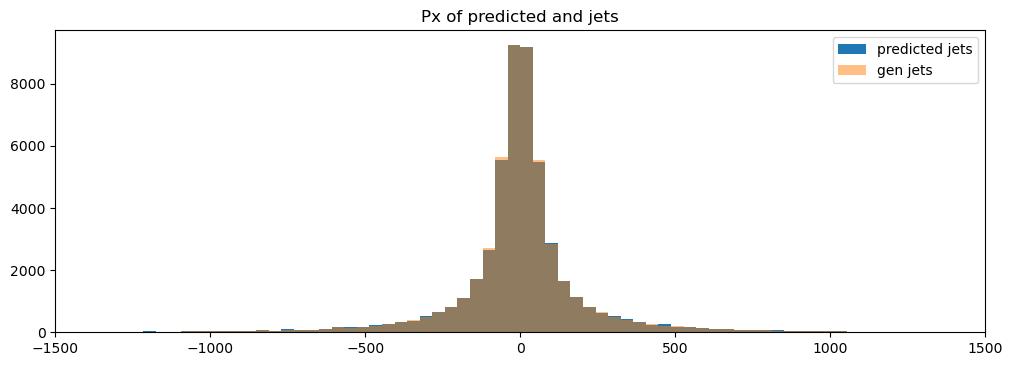

In [30]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 0], bins=bins, label='predicted jets')
ax1.hist(true[:, 0], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Px of predicted and jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

## Histograms of Py

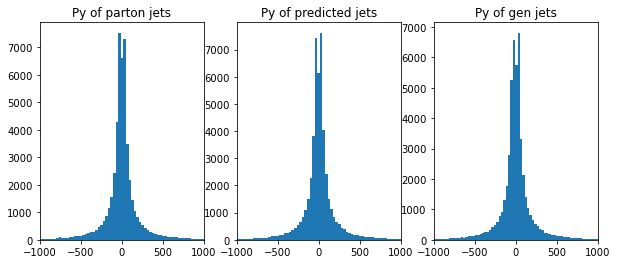

In [14]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 1], bins=200)
ax1.set_title("Py of parton jets")
ax1.set_xlim(-1000, 1000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 1], bins=200)
ax2.set_title("Py of predicted jets")
ax2.set_xlim(-1000, 1000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 1], bins=200)
ax3.set_title("Py of gen jets")
ax3.set_xlim(-1000, 1000)
#plt.yscale('log')
plt.show()

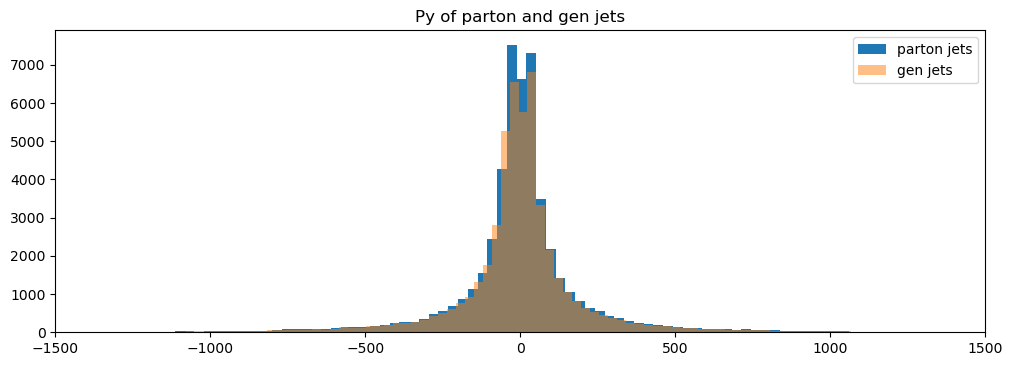

In [15]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 1], bins=200, label='parton jets')
ax1.hist(true[:, 1], bins=200, label='gen jets', alpha=0.5)
ax1.set_title("Py of parton and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

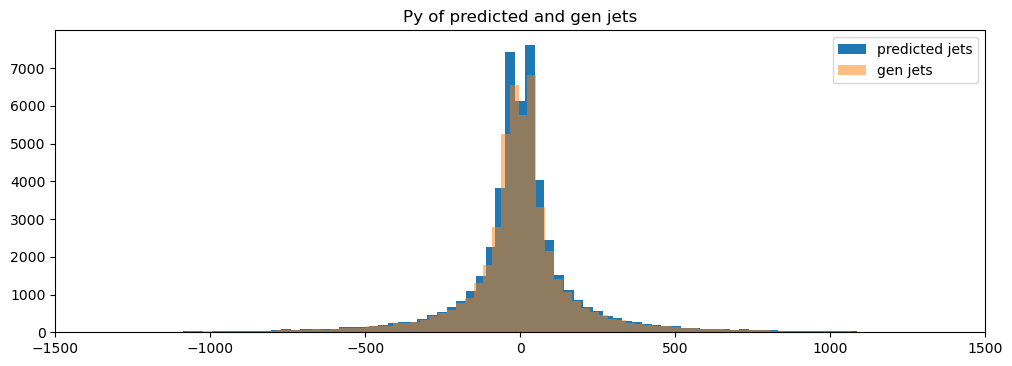

In [16]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 1], bins=200, label='predicted jets')
ax1.hist(true[:, 1], bins=200, label='gen jets', alpha=0.5)
ax1.set_title("Py of predicted and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

## Histograms for Pz

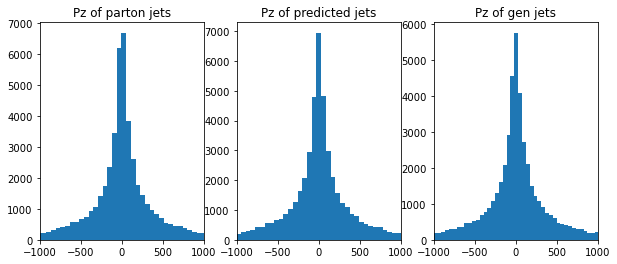

In [17]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 2], bins=200)
ax1.set_title("Pz of parton jets")
ax1.set_xlim(-1000, 1000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 2], bins=200)
ax2.set_title("Pz of predicted jets")
ax2.set_xlim(-1000, 1000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 2], bins=200)
ax3.set_title("Pz of gen jets")
ax3.set_xlim(-1000, 1000)
#plt.yscale('log')
plt.show()

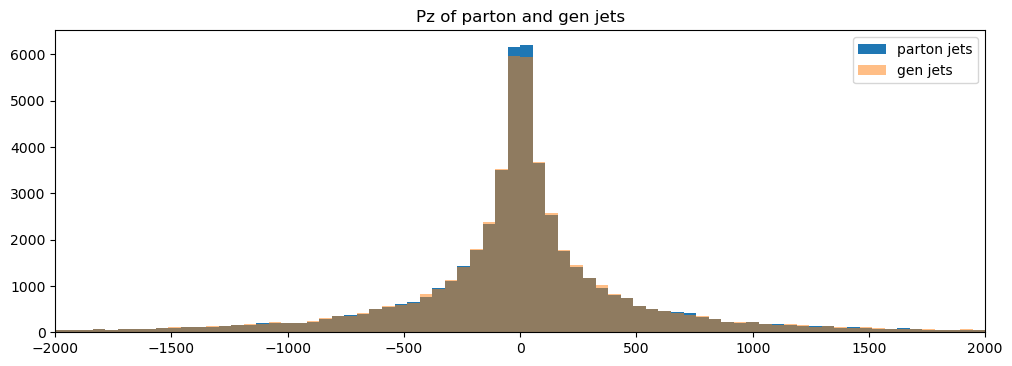

In [31]:
bins = np.linspace(-2000, 2000, 75)
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 2], bins=bins, label='parton jets')
ax1.hist(true[:, 2], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Pz of parton and gen jets")
ax1.set_xlim(-2000, 2000)
ax1.legend()
plt.show()

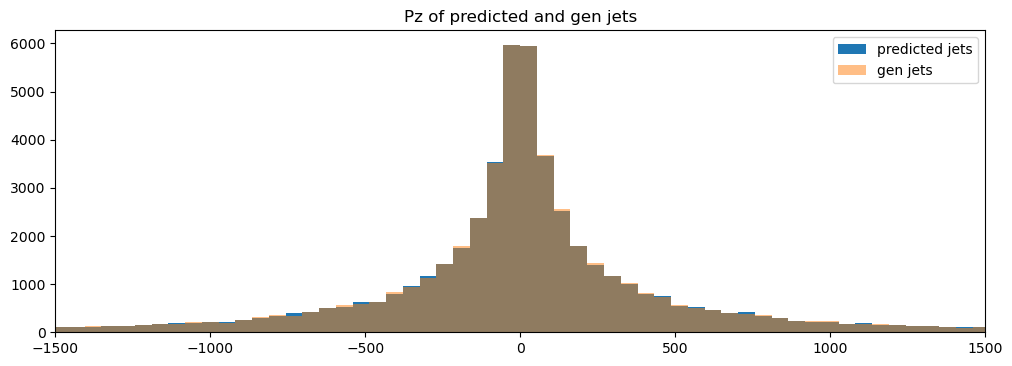

In [32]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 2], bins=bins, label='predicted jets')
ax1.hist(true[:, 2], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Pz of predicted and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

## Energy histograms

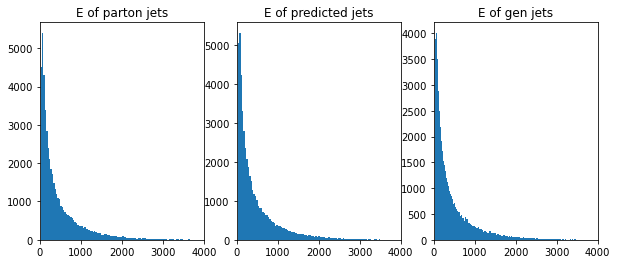

In [20]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 3], bins=200)
ax1.set_title("E of parton jets")
ax1.set_xlim(0, 4000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 3], bins=200)
ax2.set_title("E of predicted jets")
ax2.set_xlim(0, 4000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 3], bins=200)
ax3.set_title("E of gen jets")
ax3.set_xlim(0, 4000)
#plt.yscale('log')
plt.show()

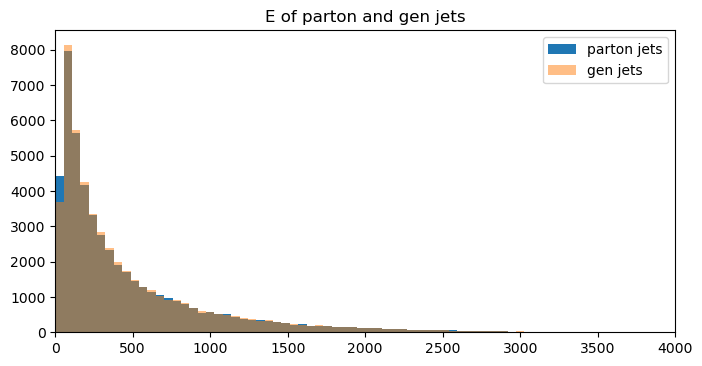

In [21]:
bins = np.linspace(0, 4000, 75)
fig = plt.figure(figsize=(8,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 3], bins=bins, label='parton jets')
ax1.hist(true[:, 3], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("E of parton and gen jets")
ax1.set_xlim(0, 4000)
ax1.legend()
plt.show()

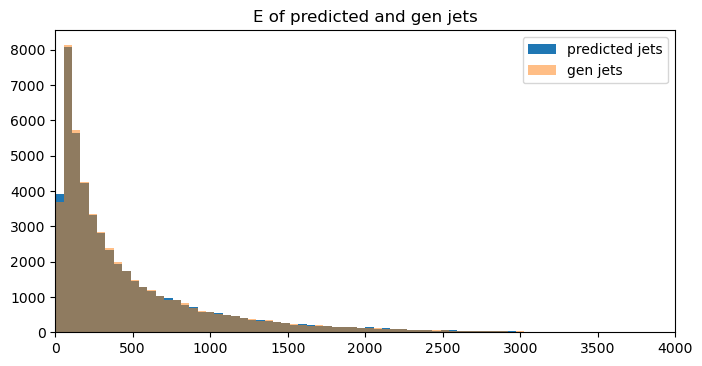

In [22]:
fig = plt.figure(figsize=(8,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 3], bins=bins, label='predicted jets')
ax1.hist(true[:, 3], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("E of predicted and gen jets")
ax1.set_xlim(0, 4000)
ax1.legend()
plt.show()

## Pt histograms

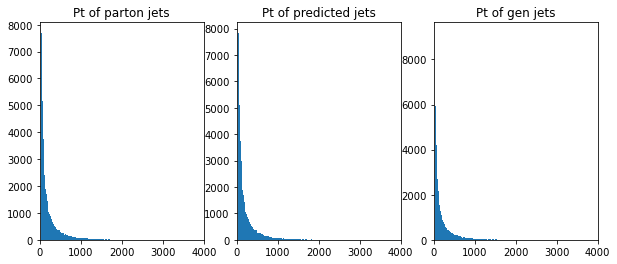

In [23]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(np.sqrt((inputs[:, 0])**2 + (inputs[:, 1])**2), bins=200)
ax1.set_title("Pt of parton jets")
ax1.set_xlim(0, 4000)
ax2 = fig.add_subplot(132)
ax2.hist(np.sqrt((prediction[:, 0])**2 + (prediction[:, 1])**2), bins=200)
ax2.set_title("Pt of predicted jets")
ax2.set_xlim(0, 4000)
ax3 = fig.add_subplot(133)
ax3.hist(np.sqrt((true[:, 0])**2 + (true[:, 1])**2), bins=200)
ax3.set_title("Pt of gen jets")
ax3.set_xlim(0, 4000)
#plt.yscale('log')
plt.show()

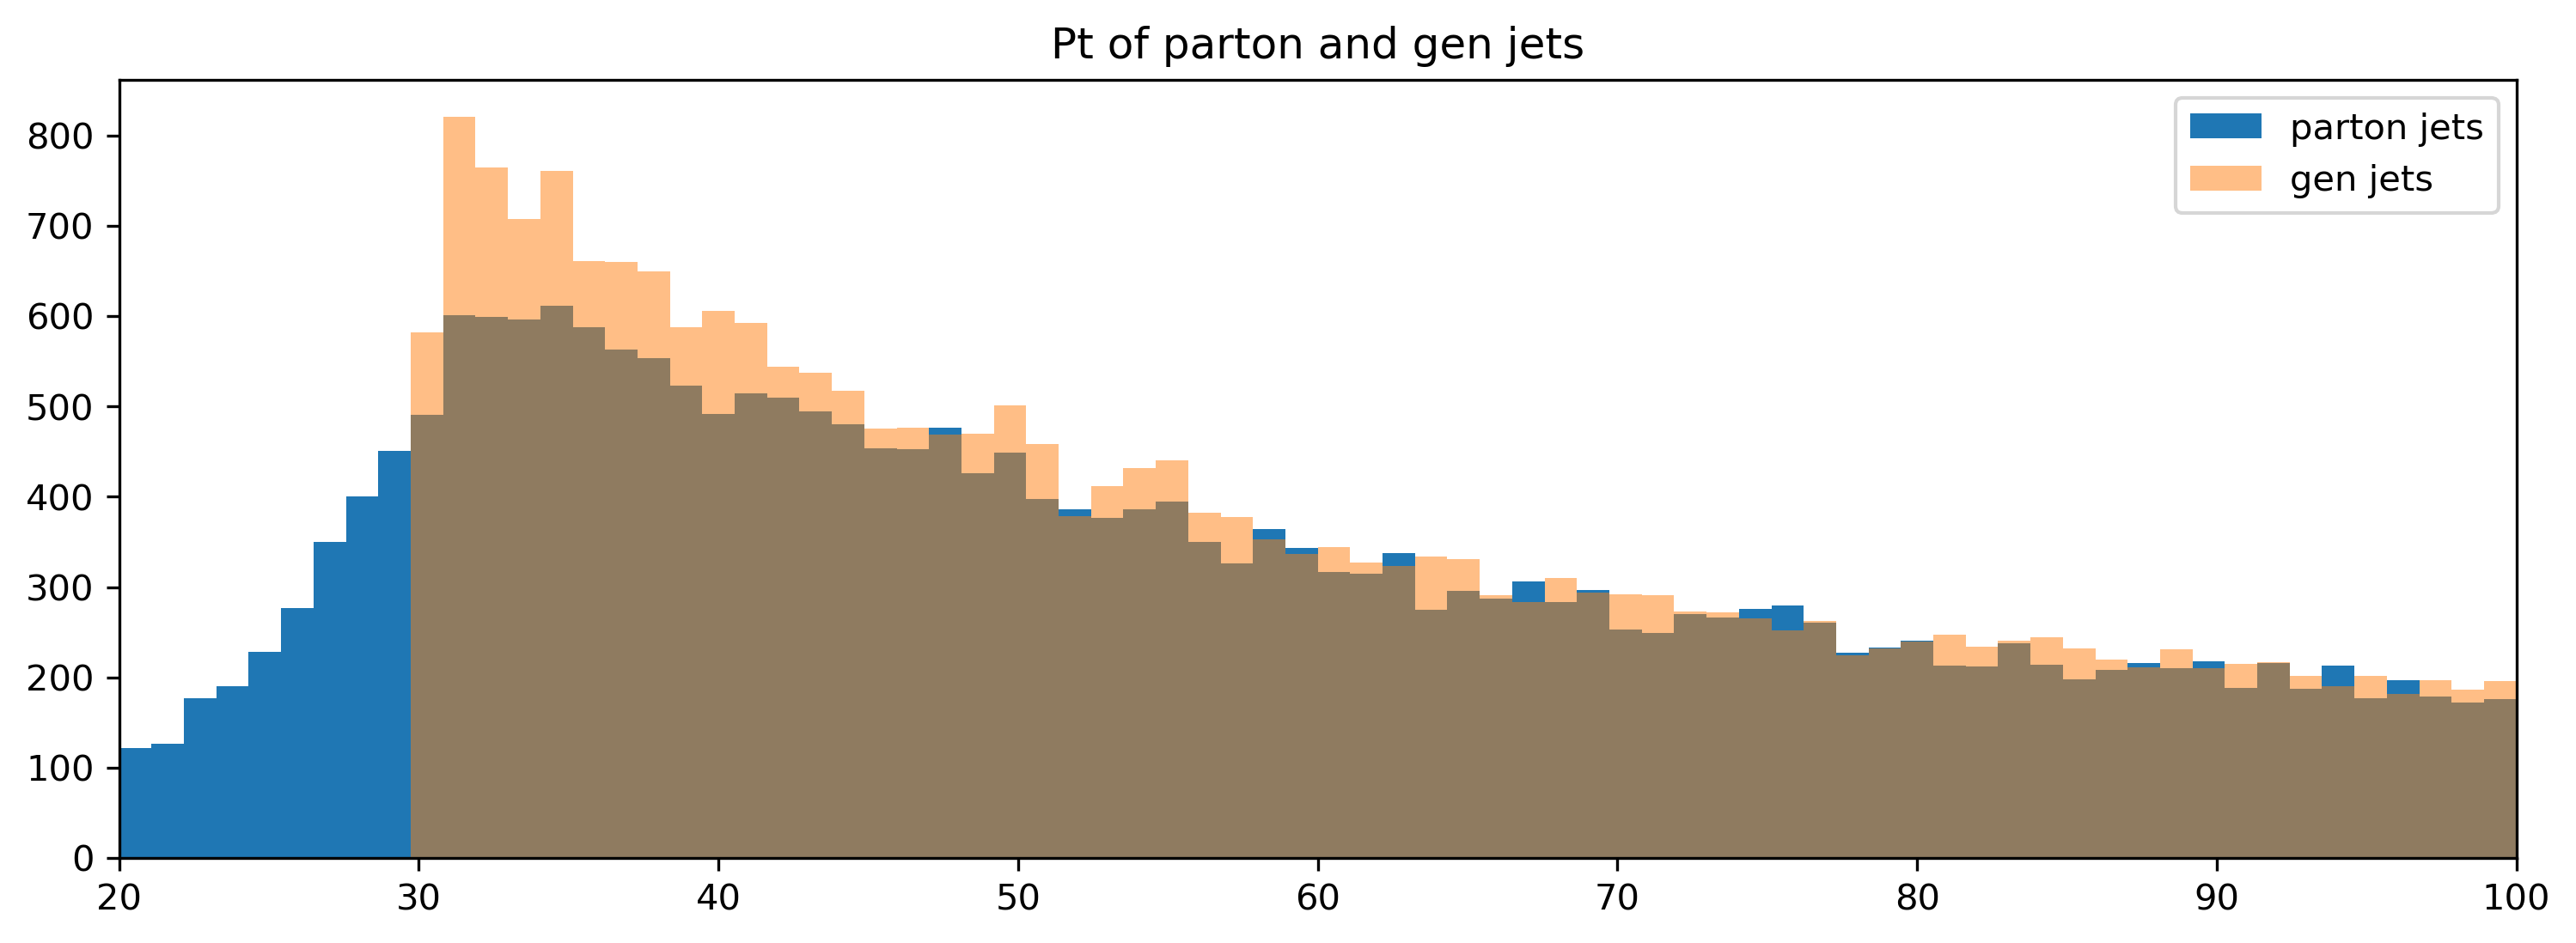

In [37]:
bins_spacing = np.linspace(20, 100, 75)
fig = plt.figure(figsize=(12,4), dpi=300)
ax1 = fig.add_subplot(111)
ax1.hist(np.sqrt((inputs[:, 0])**2 + (inputs[:, 1])**2), bins=bins_spacing, label='parton jets')
ax1.hist(np.sqrt((true[:, 0])**2 + (true[:, 1])**2), bins=bins_spacing, label='gen jets', alpha=0.5)
ax1.set_title("Pt of parton and gen jets")
ax1.set_xlim(20, 100)
ax1.legend()
plt.show()

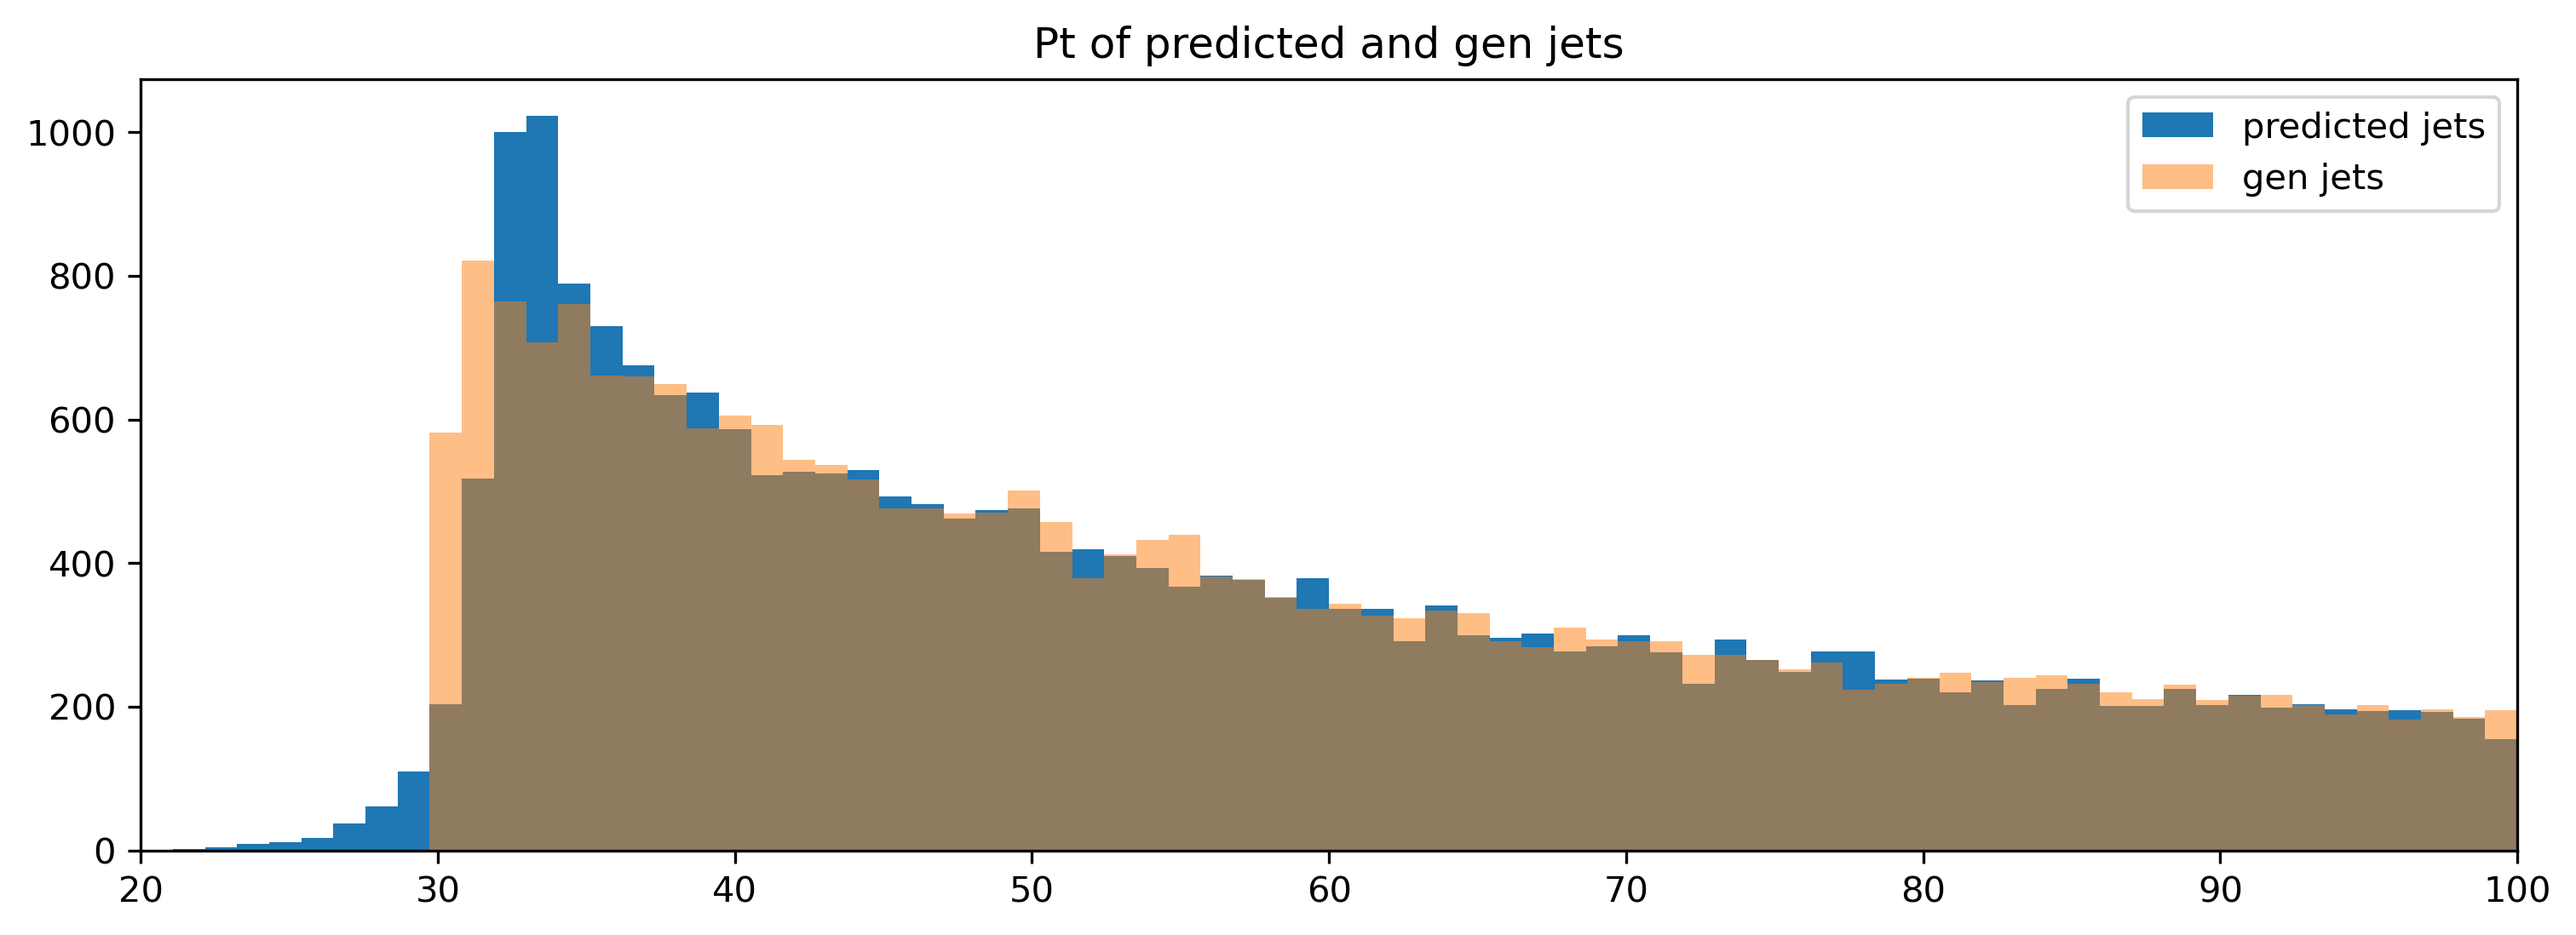

In [38]:
fig = plt.figure(figsize=(12,4), dpi=300)
ax1 = fig.add_subplot(111)
ax1.hist(np.sqrt((prediction[:, 0])**2 + (prediction[:, 1])**2), bins=bins_spacing, label='predicted jets')
ax1.hist(np.sqrt((true[:, 0])**2 + (true[:, 1])**2), bins=bins_spacing, label='gen jets', alpha=0.5)
ax1.set_title("Pt of predicted and gen jets")
ax1.set_xlim(20, 100)
ax1.legend()
plt.show()

## Calculating delta R

In [26]:
def theta(vec):
    pt = np.sqrt((vec[:, 0])**2 + (vec[:, 1])**2)
    return np.arctan2(pt, vec[:, 2])

def phi(vec):
    return np.arctan2(vec[:, 1], vec[:, 0])

def eta(vec):
    return -np.log(np.tan(theta(vec)/2))

def deltaR(vec1, vec2):
    return (np.sqrt((eta(vec1)-eta(vec2))**2 + (phi(vec1)-phi(vec2))**2))

#testing theta - should return [0.693, 0.549]
arr = np.array(([1, 2, 3, 5],[3, -1, 4, 8]), dtype=float)
print(theta(arr))
print(phi(arr))

[0.64052231 0.66896407]
[ 1.10714872 -0.32175055]


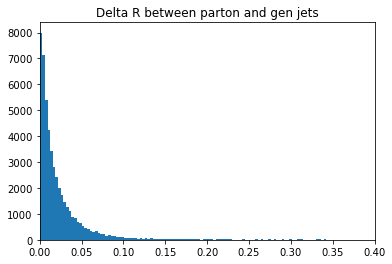

In [27]:
deltaRPartonsGen = deltaR(inputs, true)
#print(deltaRPartonsGen.shape)
plt.hist(deltaRPartonsGen, bins=2000)
plt.xlim(0,0.4)
plt.title("Delta R between parton and gen jets")
plt.show()

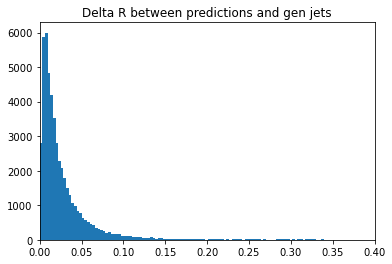

In [28]:
deltaRPredictionGen = deltaR(prediction, true)
#print(deltaRPartonsGen.shape)
plt.hist(deltaRPredictionGen, bins=2000)
plt.xlim(0,0.4)
plt.title("Delta R between predictions and gen jets")
plt.show()